# Platform frequency response demo

Set up notebook.

In [1]:
# Import modules
import time
import numpy as np
from scipy import linalg
from scipy import signal
import sympy as sym
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import ae353_platform

# Enable interactive plots
%matplotlib widget

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

pybullet build time: Dec 10 2021 09:55:58


Create a simulator.

In [2]:
simulator = ae353_platform.Simulator(
    display=True,
    roll=0.,
)

Define the state-space model.

In [3]:
# Equilibrium point
q_e = 0.
v_e = 0.
tau_e = 0.

# Jacobian matrices
A = np.array([[0., 1.], [0., 0.]])
B = np.array([[0.], [1.]])

Do control design by eigenvalue placement.

In [4]:
K = signal.place_poles(A, B, [-1. + 2. * 1j, -1. - 2. * 1j]).gain_matrix
print(f'K = np.array({K.tolist()})')

K = np.array([[5.0, 2.0]])


Do control implementation to track a sinusoidal desired platform angle.

In [5]:
class Controller:
    def __init__(self, K, q_e, v_e, tau_e):
        self.K = K
        self.q_e = q_e
        self.v_e = v_e
        self.tau_e = tau_e
        
        # Tell the simlator to log the desired platform angle
        self.variables_to_log = ['q_des']
    
    def reset(self):
        self.q_des = 0.
    
    def run(
            self,
            t,
            platform_angle,
            platform_velocity,
            wheel_angle,
            wheel_velocity,
        ):
        
        # Find state
        x = np.array([
            platform_angle - self.q_e,
            platform_velocity - self.v_e,
        ])
        
        # Choose desired platform angle
        w = 5.
        self.q_des = np.sin(w * t)
        
        # Find desired state and input
        x_des = np.array([
            self.q_des - self.q_e,
            0. - self.v_e,
        ])
        u_des = np.array([
            0. - self.q_e,
        ])
        
        # Find input
        u = u_des - self.K @ (x - x_des)
        
        # Find torque applied to the platform
        tau = u[0] + self.tau_e
        
        # Find (and return) equal and opposite torque applied to the wheel
        wheel_torque = -tau
        return wheel_torque

Run simulation.

In [6]:
# Create controller
controller = Controller(K, q_e, v_e, tau_e)
    
# Reset simulator
simulator.reset(
    platform_angle=0.,
    platform_velocity=0.,
    wheel_angle=0.,
    wheel_velocity=0.,
)

# Reset controller
controller.reset()

# Run simulator
data = simulator.run(
    controller,
    max_time=10.,
)

Plot results.

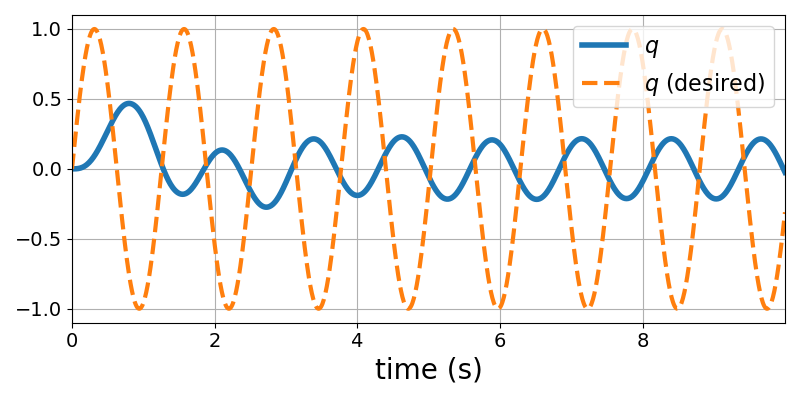

In [7]:
t = data['t']
q = data['platform_angle']
v = data['platform_velocity']
tau = - data['wheel_torque']
q_des = data['q_des']

fig, ax_q = plt.subplots(1, 1, figsize=(8, 4), sharex=True)

ax_q.plot(t, q, label=r'$q$', linewidth=4)
ax_q.plot(t, q_des, '--', label=r'$q$ (desired)', linewidth=3)
ax_q.grid()
ax_q.legend(fontsize=16)
ax_q.tick_params(labelsize=14)

# ax_v.plot(t, v, label=r'$v$', linewidth=4)
# ax_v.grid()
# ax_v.legend(fontsize=16)
# ax_v.tick_params(labelsize=14)

# ax_tau.plot(t, tau, label=r'$\tau$', linewidth=4)
# ax_tau.plot(t, np.ones_like(tau) * simulator.tau_max, '--', color='C1', linewidth=2)
# ax_tau.plot(t, - np.ones_like(tau) * simulator.tau_max, '--', color='C1', linewidth=2)
# ax_tau.grid()
# ax_tau.legend(fontsize=16)
# ax_tau.tick_params(labelsize=14)

ax_q.set_xlabel('time (s)', fontsize=20)
ax_q.set_xlim([data['t'][0], data['t'][-1]])

fig.tight_layout()
plt.show()

In [8]:
T = 8.394 - 7.142
print(T)

w = 2 * np.pi / T
print(w)

1.2519999999999998
5.018518615958137


In [9]:
ang = 2 * np.pi * ((7.142 - 6.593) / T)
print(ang)

2.7551667201610193


In [10]:
T = 39.72 - 33.41
print(T)

w = 2 * np.pi / T
print(w)

6.310000000000002
0.9957504448779055


In [11]:
ang = 2 * np.pi * ((33.41 - 32.96) / T)
print(ang)

0.4480877001950533


In [12]:
ang = 2 * np.pi * ((35.997 - 35.329) / (2 * np.pi / 2))
print(ang)

1.3359999999999985


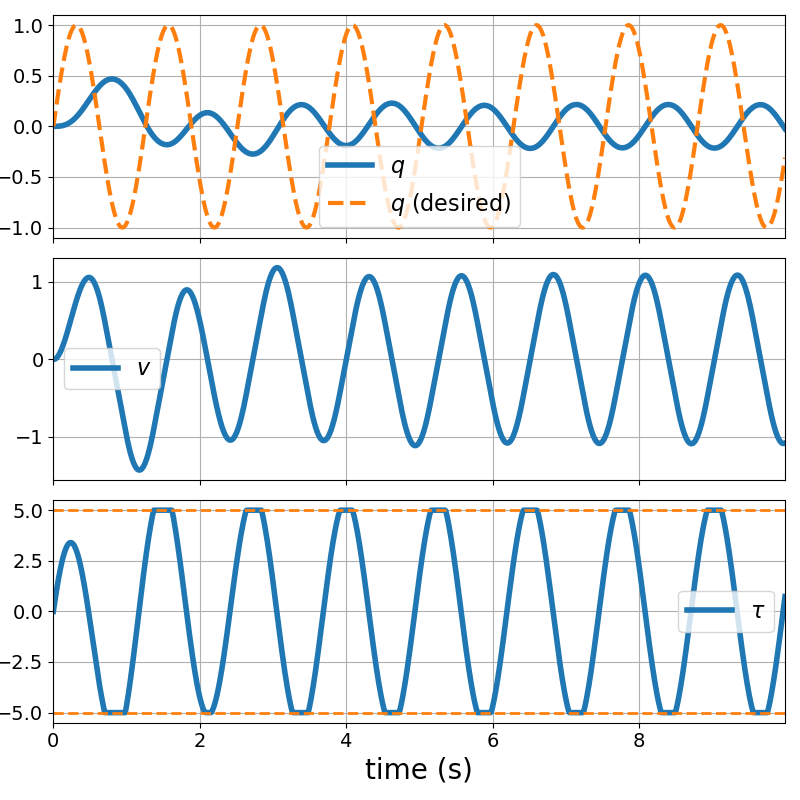

In [13]:
t = data['t']
q = data['platform_angle']
v = data['platform_velocity']
tau = - data['wheel_torque']
q_des = data['q_des']

fig, (ax_q, ax_v, ax_tau) = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

ax_q.plot(t, q, label=r'$q$', linewidth=4)
ax_q.plot(t, q_des, '--', label=r'$q$ (desired)', linewidth=3)
ax_q.grid()
ax_q.legend(fontsize=16)
ax_q.tick_params(labelsize=14)

ax_v.plot(t, v, label=r'$v$', linewidth=4)
ax_v.grid()
ax_v.legend(fontsize=16)
ax_v.tick_params(labelsize=14)

ax_tau.plot(t, tau, label=r'$\tau$', linewidth=4)
ax_tau.plot(t, np.ones_like(tau) * simulator.tau_max, '--', color='C1', linewidth=2)
ax_tau.plot(t, - np.ones_like(tau) * simulator.tau_max, '--', color='C1', linewidth=2)
ax_tau.grid()
ax_tau.legend(fontsize=16)
ax_tau.tick_params(labelsize=14)

ax_tau.set_xlabel('time (s)', fontsize=20)
ax_tau.set_xlim([data['t'][0], data['t'][-1]])

fig.tight_layout()
plt.show()

Define a matrix that picks the *only* element of $x_\text{des}$ that varies.

In [14]:
M = np.array([[1.], [0.]])

Define closed-loop model.

In [15]:
Am = A - B @ K
Bm = - (A - B @ K) @ M
Cm = M.T

print(Am)
print(Bm)
print(Cm)

[[ 0.  1.]
 [-5. -2.]]
[[0.]
 [5.]]
[[1. 0.]]


Define the function

$$H(s) = C_m (s - A_m)^{-1} B_m$$

where $s\in\mathbb{C}$ is a complex number.

In [16]:
H = lambda s: (Cm @ linalg.inv(s * np.eye(Am.shape[0]) - Am) @ Bm).item()

Find the magnitude $|H(j\omega)|$ and the angle $\angle H(j\omega)$ of the complex number $H(j\omega)$ for different choices of frequency $\omega$ (radians / second).

Remember that any complex number $z\in\mathbb{C}$ can be written as

$$z = |z|e^{\angle z} = |z| \left( \cos(\angle z) + j \sin(\angle z) \right)$$

and that the period $T$ (in seconds) of a sinusoid with frequency $\omega$ (in radians / second) is

$$T = \dfrac{2\pi}{\omega}.$$

In [17]:
omega = 1.
H_of_jomega = H(1j * omega)
magH = np.absolute(H_of_jomega)
angH = np.angle(H_of_jomega)

print(f'omega = {omega}')
print(f'H(j omega) = {H_of_jomega:.4f}')
print(f'mag = {magH:.4f}')
print(f'ang = {angH:.4f}')

omega = 1.0
H(j omega) = 1.0000-0.5000j
mag = 1.1180
ang = -0.4636


In [ ]:
omega = 2.
H_of_jomega = H(1j * omega)
magH = np.absolute(H_of_jomega)
angH = np.angle(H_of_jomega)

print(f'omega = {omega}')
print(f'H(j omega) = {H_of_jomega:.4f}')
print(f'mag = {magH:.4f}')
print(f'ang = {angH:.4f}')

In [ ]:
omega = 5.
H_of_jomega = H(1j * omega)
magH = np.absolute(H_of_jomega)
angH = np.angle(H_of_jomega)

print(f'omega = {omega}')
print(f'H(j omega) = {H_of_jomega:.4f}')
print(f'mag = {magH:.4f}')
print(f'ang = {angH:.4f}')

Create Bode plot (i.e., plot magnitude and angle of $H(jw)$ as $w$ varies).

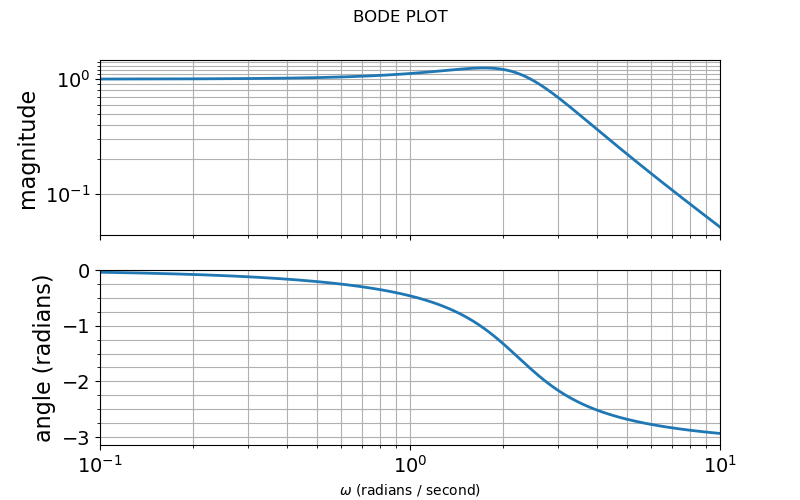

In [19]:
omega = np.logspace(-1, 1, 250)
H_at_jomega = np.empty_like(omega, dtype=complex)
for i in range(len(omega)):
    H_at_jomega[i] = H(1j * omega[i])
mag = np.absolute(H_at_jomega)
ang = np.angle(H_at_jomega)

fig, (ax_mag, ax_ang) = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
ax_mag.loglog(omega, mag, linewidth=2)
ax_mag.grid(visible=True, which='both', axis='both')
ax_mag.tick_params(labelsize=14)
ax_mag.yaxis.set_minor_locator(MultipleLocator(1e-1))
ax_mag.set_yticklabels([], minor=True)
ax_mag.set_ylabel('magnitude', fontsize=16)
ax_ang.semilogx(omega, ang, linewidth=2)
ax_ang.grid(visible=True, which='both', axis='both')
ax_ang.tick_params(labelsize=14)
ax_ang.yaxis.set_minor_locator(MultipleLocator(0.25))
ax_ang.set_yticklabels([], minor=True)
ax_ang.set_ylabel('angle (radians)', fontsize=16)
ax_ang.set_ylim([-np.pi, 0.])
ax_ang.set_xlim([min(omega), max(omega)])
ax_ang.set_xlabel(r'$\omega$ (radians / second)')
fig.suptitle('BODE PLOT')
plt.show()

Show Bode plot again in dB and degrees.

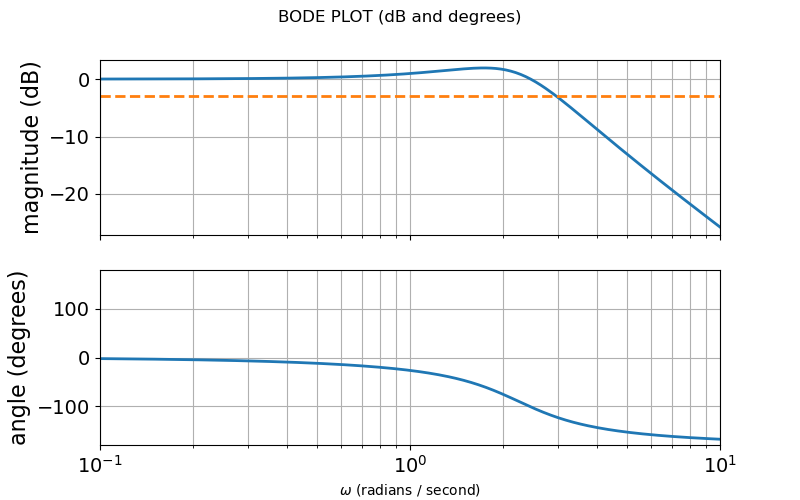

In [21]:
omega = np.logspace(-1, 1, 250)
H_at_jomega = np.empty_like(omega, dtype=complex)
for i in range(len(omega)):
    H_at_jomega[i] = H(1j * omega[i])
mag = 20 * np.log10(np.absolute(H_at_jomega))
ang = np.rad2deg(np.angle(H_at_jomega))

fig, (ax_mag, ax_ang) = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
ax_mag.semilogx(omega, mag, linewidth=2)
ax_mag.semilogx(omega, -3. * np.ones_like(omega), '--', linewidth=2)
ax_mag.grid(visible=True, which='both', axis='both')
ax_mag.tick_params(labelsize=14)
ax_mag.yaxis.set_minor_locator(MultipleLocator(10))
ax_mag.set_yticklabels([], minor=True)
ax_mag.set_ylabel('magnitude (dB)', fontsize=16)
ax_ang.semilogx(omega, ang, linewidth=2)
ax_ang.grid(visible=True, which='both', axis='both')
ax_ang.tick_params(labelsize=14)
# ax_ang.yaxis.set_minor_locator(MultipleLocator(0.25))
ax_ang.set_yticklabels([], minor=True)
ax_ang.set_ylabel('angle (degrees)', fontsize=16)
ax_ang.set_ylim([-180, 180])
ax_ang.set_xlim([min(omega), max(omega)])
ax_ang.set_xlabel(r'$\omega$ (radians / second)')
fig.suptitle('BODE PLOT (dB and degrees)')
plt.show()